In [18]:
# Import necessary libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from haversine import haversine

# Load the CSV file
df = pd.read_csv('../results/rotas_clusters.csv')

# Function to calculate the distance between two points using the Haversine formula
def calculate_distance(row):
    coords_1 = (row['LATITUDE'], row['LONGITUDE'])
    coords_2 = (row['NEXT_LATITUDE'], row['NEXT_LONGITUDE'])
    return haversine(coords_1, coords_2)

# Calculate the total distance and total time per route
df['NEXT_LATITUDE'] = df.groupby(['CLUSTER', 'ROTA'])['LATITUDE'].shift(-1)
df['NEXT_LONGITUDE'] = df.groupby(['CLUSTER', 'ROTA'])['LONGITUDE'].shift(-1)
df['DISTANCE'] = df.apply(lambda row: calculate_distance(row) if pd.notnull(row['NEXT_LATITUDE']) else 0, axis=1)

# Function to calculate the total travel time (reading time + travel time)
def calculate_time(row):
    speed_kmh = 5  # Average speed in km/h
    read_time = 2  # Reading time in minutes
    travel_time = (row['DISTANCE'] / speed_kmh) * 60  # Travel time in minutes
    return travel_time + read_time

df['TIME'] = df.apply(calculate_time, axis=1)

# Grouping the data to obtain metrics per route
route_metrics = df.groupby(['CLUSTER', 'ROTA']).agg(
    total_distance=('DISTANCE', 'sum'),
    total_time=('TIME', 'sum'),
    num_points=('INDICE', 'count')
).reset_index()

# Calculate IQRs and identify outliers
# Removing outliers because they are likely isolated points that skew the metrics. This might not occur when processing 100% of the data.
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers_time = identify_outliers(route_metrics, 'total_time')
outliers_distance = identify_outliers(route_metrics, 'total_distance')
outliers_points = identify_outliers(route_metrics, 'num_points')

# Removing the outliers
route_metrics_no_outliers = route_metrics[
    ~route_metrics.index.isin(outliers_time.index) &
    ~route_metrics.index.isin(outliers_distance.index) &
    ~route_metrics.index.isin(outliers_points.index)
]

# Calculate averages and variances without outliers
average_time = route_metrics_no_outliers['total_time'].mean()
variance_time = route_metrics_no_outliers['total_time'].var()

average_distance = route_metrics_no_outliers['total_distance'].mean()
variance_distance = route_metrics_no_outliers['total_distance'].var()

average_points = route_metrics_no_outliers['num_points'].mean()
variance_points = route_metrics_no_outliers['num_points'].var()

# Create the charts
fig_avg_time = go.Figure()
fig_avg_time.add_trace(go.Bar(
    x=['Average Time'],
    y=[average_time],
    name='Average Time'
))
fig_avg_time.add_trace(go.Bar(
    x=['Variance Time'],
    y=[variance_time],
    name='Variance Time'
))
fig_avg_time.update_layout(title='Average and Variance of Time per Route', barmode='group')
fig_avg_time.show()

fig_avg_distance = go.Figure()
fig_avg_distance.add_trace(go.Bar(
    x=['Average Distance'],
    y=[average_distance],
    name='Average Distance'
))
fig_avg_distance.add_trace(go.Bar(
    x=['Variance Distance'],
    y=[variance_distance],
    name='Variance Distance'
))
fig_avg_distance.update_layout(title='Average and Variance of Distance per Route', barmode='group')
fig_avg_distance.show()

fig_avg_points = go.Figure()
fig_avg_points.add_trace(go.Bar(
    x=['Average Points'],
    y=[average_points],
    name='Average Points'
))
fig_avg_points.add_trace(go.Bar(
    x=['Variance Points'],
    y=[variance_points],
    name='Variance Points'
))
fig_avg_points.update_layout(title='Average and Variance of Points per Route', barmode='group')
fig_avg_points.show()

# Display the removed outliers
outliers = pd.concat([outliers_time, outliers_distance, outliers_points]).drop_duplicates()
print("Removed outliers:")
print(outliers)

# Interactive plot of clusters on the map
fig_clusters = px.scatter_mapbox(df, lat='LATITUDE', lon='LONGITUDE', color='CLUSTER', 
                                 mapbox_style="carto-positron", zoom=10,
                                 title="Clusters on the Map")
fig_clusters.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_clusters.show()


Removed outliers:
     CLUSTER  ROTA  total_distance  total_time  num_points
628     2725     0        2.430211  315.162538         143


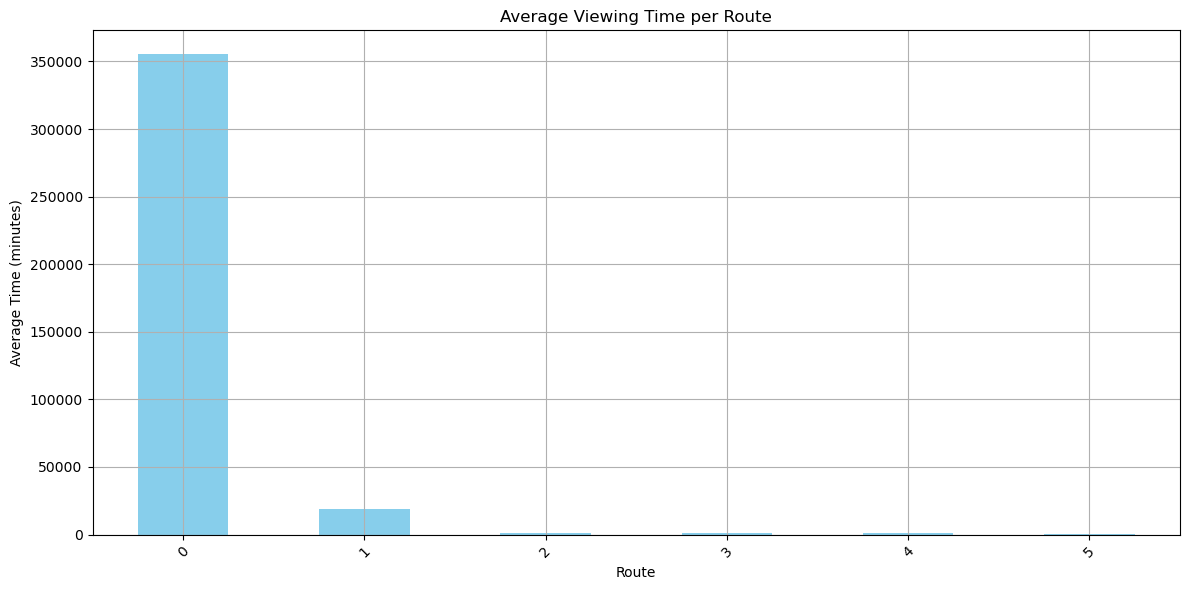

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the routes data
df_routes = pd.read_csv("../results/rotas_clusters.csv")

# Assuming each point takes 2 minutes to read plus travel time between points
# We need to calculate travel time between each point in a route, using a constant speed and haversine formula
# For simplicity, we'll just assume each point takes a total of 5 minutes for now, which includes reading and travel

# Calculate total time per route
df_routes['Time'] = 5  # Add a column for time spent per point (simplified as constant 5 minutes for this example)
df_routes['Total Time'] = df_routes.groupby('ROTA')['Time'].transform('sum')  # Sum of time per route

# Calculate average time per route
average_time_per_route = df_routes.groupby('ROTA')['Total Time'].mean()

# Plotting the average time per route
fig, ax = plt.subplots(figsize=(12, 6))
average_time_per_route.plot(kind='bar', color='skyblue', ax=ax)
plt.title('Average Viewing Time per Route')
plt.xlabel('Route')
plt.ylabel('Average Time (minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
from haversine import haversine

# Load the routes data
df_routes = pd.read_csv("../results/rotas_clusters.csv")

# Sort by route and cluster for correct sequence calculation
df_routes.sort_values(by=['CLUSTER', 'ROTA'], inplace=True)

# Calculate distance to next point in the same route
def calculate_next_point_distance(row, df):
    current_index = df.index.get_loc(row.name)
    if current_index + 1 < len(df):
        next_point = df.iloc[current_index + 1]
        if row['ROTA'] == next_point['ROTA']:  # Check if the next point is in the same route
            return haversine((row['LATITUDE'], row['LONGITUDE']), (next_point['LATITUDE'], next_point['LONGITUDE']), unit='km')
    return 0

df_routes['Distance'] = df_routes.apply(calculate_next_point_distance, axis=1, df=df_routes)
df_routes['Travel Time'] = df_routes['Distance'] / 5 * 60  # Speed of 5 km/h, converted to minutes
df_routes['Total Time per Point'] = df_routes['Travel Time'] + 2  # Adding 2 minutes for reading time

# Calculate total time per route
df_routes['Total Time per Route'] = df_routes.groupby(['CLUSTER', 'ROTA'])['Total Time per Point'].transform('sum')

# Calculate average time per route
average_time_per_route = df_routes.groupby(['CLUSTER', 'ROTA'])['Total Time per Route'].mean()

# Calculate the overall average time across all points
overall_average_time = df_routes['Total Time per Point'].mean()

print(f"Overall average time per point: {overall_average_time:.2f} minutes")


Overall average time per point: 2.74 minutes


In [21]:
import pandas as pd
from haversine import haversine

# Load the routes data
df_routes = pd.read_csv("../results/rotas_clusters.csv")

# Sort by route and cluster for correct sequence calculation
df_routes.sort_values(by=['CLUSTER', 'ROTA'], inplace=True)

# Calculate distance to next point in the same route
def calculate_next_point_distance(row, df):
    current_index = df.index.get_loc(row.name)
    if current_index + 1 < len(df):
        next_point = df.iloc[current_index + 1]
        if row['ROTA'] == next_point['ROTA']:  # Check if the next point is in the same route
            return haversine((row['LATITUDE'], row['LONGITUDE']), (next_point['LATITUDE'], next_point['LONGITUDE']), unit='km')
    return 0

df_routes['Distance'] = df_routes.apply(calculate_next_point_distance, axis=1, df=df_routes)
df_routes['Travel Time'] = df_routes['Distance'] / 5 * 60  # Speed of 5 km/h, converted to minutes
df_routes['Total Time per Point'] = df_routes['Travel Time'] + 2  # Adding 2 minutes for reading time

# Calculate total time per route
df_routes['Total Time per Route'] = df_routes.groupby(['CLUSTER', 'ROTA'])['Total Time per Point'].transform('sum')
    
# Calculate the number of points per route
points_per_route = df_routes.groupby(['CLUSTER', 'ROTA']).size()

# Calculate the overall average number of points per route
overall_average_points_per_route = points_per_route.mean()

# Display overall average number of points per route
print(f"Overall average number of points per route: {overall_average_points_per_route:.2f}")


Overall average number of points per route: 100.74


Calculating routes:   0%|          | 0/750 [00:00<?, ?it/s]

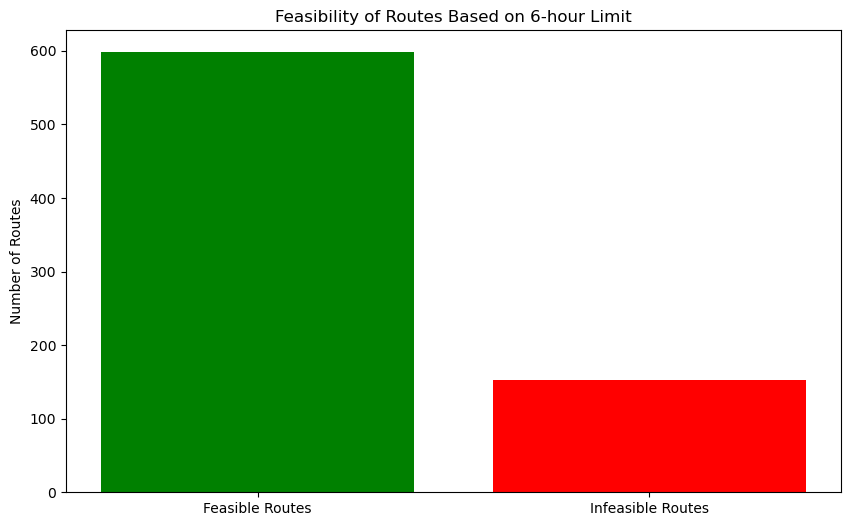

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from haversine import haversine
from tqdm.notebook import tqdm  # tqdm for notebooks

# Função para calcular o tempo total e a distância de uma rota
def calculate_route_details(df):
    total_time = 0
    total_distance = 0
    speed = 5  # Velocidade em km/h
    read_time = 2  # Tempo de parada em minutos

    # Ordenar os dados pela sequência para garantir a ordem correta
    df.sort_values('SEQUENCIA', inplace=True)

    for i in range(len(df) - 1):
        loc1 = (df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE'])
        loc2 = (df.iloc[i+1]['LATITUDE'], df.iloc[i+1]['LONGITUDE'])
        distance = haversine(loc1, loc2)
        travel_time = (distance / speed) * 60  # Convertendo horas para minutos
        total_time += travel_time + read_time
        total_distance += distance

    return total_time

# Função para determinar a viabilidade de uma rota
def is_route_feasible(total_time, max_time=360):
    return total_time <= max_time

# Carregar os dados
file_path = '../results/rotas_clusters.csv'  # Modifique para o caminho do seu arquivo
df = pd.read_csv(file_path)

# Agrupar por CLUSTER e ROTA
route_groups = df.groupby(['CLUSTER', 'ROTA'])

feasible_count = 0
infeasible_count = 0
for (cluster, route), group in tqdm(route_groups, desc='Calculating routes'):
    total_time = calculate_route_details(group)
    if is_route_feasible(total_time):
        feasible_count += 1
    else:
        infeasible_count += 1

# Gerar gráfico de barras
labels = ['Feasible Routes', 'Infeasible Routes']
values = [feasible_count, infeasible_count]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['green', 'red'])
plt.title('Feasibility of Routes Based on 6-hour Limit')
plt.ylabel('Number of Routes')
plt.show()


In [23]:
import plotly.express as px
import plotly.graph_objects as go

# Calculate the average total time per route
average_total_time = df_routes['Total Time per Route'].mean()

# Define a threshold for inefficiency
threshold = 1.5 * average_total_time

# Identify an inefficient route
inefficient_route = df_routes[df_routes['Total Time per Route'] > threshold].iloc[0]
inefficient_route_cluster = inefficient_route['CLUSTER']
inefficient_route_id = inefficient_route['ROTA']

# Filter the dataset for this specific route
specific_route = df_routes[(df_routes['CLUSTER'] == inefficient_route_cluster) & (df_routes['ROTA'] == inefficient_route_id)]

# Calculate the mean latitude and longitude for centering the map
mean_latitude = specific_route['LATITUDE'].mean()
mean_longitude = specific_route['LONGITUDE'].mean()

# Create a scatter mapbox to visualize the route
fig = px.scatter_mapbox(specific_route,
                        lat="LATITUDE",
                        lon="LONGITUDE",
                        hover_name=specific_route.index,
                        hover_data={"CLUSTER": True, "ROTA": True, "Total Time per Point": True},
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=17,  # Adjust this value based on trial and error
                        center={"lat": mean_latitude, "lon": mean_longitude},
                        height=600)

# Add lines to connect the points in the route
fig.add_trace(go.Scattermapbox(
    lon = specific_route['LONGITUDE'],
    lat = specific_route['LATITUDE'],
    mode = 'lines',
    line = dict(width = 4, color = 'blue'),
))

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Show the figure
fig.show()

# Calculate the total time for the route and print it
total_time_for_route = specific_route['Total Time per Point'].sum()/60
print(f"Total time to complete the route: {total_time_for_route:.2f} horas")


Total time to complete the route: 8.55 horas


In [24]:
import pandas as pd
import folium

# Load data
rotas_clusters = pd.read_csv('../results/rotas_clusters.csv', sep=',')
amostra_menor = pd.read_csv('../data/AMOTRA_MENOR.csv', sep=';')

# Normalize column names
rotas_clusters.columns = [col.strip().upper() for col in rotas_clusters.columns]
amostra_menor.columns = [col.strip().upper() for col in amostra_menor.columns]

# Find a common point
ponto_comum = pd.merge(rotas_clusters, amostra_menor, on=['LATITUDE', 'LONGITUDE'], how='inner')

# Check if a common point was found
if not ponto_comum.empty:
    print("Ponto em comum encontrado!")
    print(ponto_comum[['LATITUDE', 'LONGITUDE', 'CODIGO_ROTA_x', 'CODIGO_ROTA_y']].head(1))
else:
    print("Nenhum ponto em comum encontrado.")

# Define the route found
codigo_rota = ponto_comum['CODIGO_ROTA_x'].iloc[0]

# Filter the route points in both DataFrames
pontos_rota_1 = amostra_menor[amostra_menor['CODIGO_ROTA'] == codigo_rota].sort_values(by='SEQUENCIA')
pontos_rota_2 = rotas_clusters[rotas_clusters['CODIGO_ROTA'] == codigo_rota].sort_values(by='SEQUENCIA')

# Create a combined map
mapa_combinado = folium.Map(location=[pontos_rota_1['LATITUDE'].mean(), pontos_rota_1['LONGITUDE'].mean()], zoom_start=16)

# Function to plot routes
def plotar_rota(pontos_rota, cor, mapa, legenda):
    # Add CircleMarkers
    for _, ponto in pontos_rota.iterrows():
        folium.CircleMarker(
            location=[ponto['LATITUDE'], ponto['LONGITUDE']],
            radius=5,
            color=cor,
            fill=True,
            fill_color=cor
        ).add_to(mapa)

    # Create the line connecting the points
    folium.PolyLine(
        pontos_rota[['LATITUDE', 'LONGITUDE']].values,
        color=cor,
        weight=5,
        tooltip=legenda  # Adiciona a legenda aqui
    ).add_to(mapa)

# Plot each route on the map with legends
plotar_rota(pontos_rota_1, 'blue', mapa_combinado, 'Rota Grupo Onda')
plotar_rota(pontos_rota_2, 'red', mapa_combinado, 'Rota Dada Aegea')

# Display the combined map
mapa_combinado


Ponto em comum encontrado!
    LATITUDE  LONGITUDE CODIGO_ROTA_x CODIGO_ROTA_y
0 -22.813896 -43.325649        72_202        72_202
